In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/Projects/BIASlab/ThesisParallelMP`


In [2]:
using RxInfer, Random, StatsPlots, BenchmarkTools, LinearAlgebra, Profile, PProf, DrWatson, DataFrames

In [3]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (6, 6)


(6, 6)

In [4]:
includet("../parallel.jl")

In [5]:
n = 1000  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [6]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = nothing }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [7]:
struct MyCustomRule
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
    s = factorial(meta.size) / 10^8
    return Beta(one(r) + r, 2one(r) - r + s)
end

In [8]:
using ProgressMeter

In [9]:
function execute_benchmark(f::F, n = 1000) where { F }
    
    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)
    
    for i in 1:n
        times[i] = f()
    end
    
    return times
end

execute_benchmark (generic function with 2 methods)

In [51]:
function prepare_benchmark(prod, pipeline, dataset, prior, meta, niterations = 100)
    return () -> begin 
        timing = Ref(0.0)
        current_iter = Ref(0.0)
        infer(
            model = coin_model(length(dataset), prior, prod, pipeline, meta),
            data  = (y = dataset, ),
            callbacks = (
                before_iteration = (model, iteration) -> begin 
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin 
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations = niterations
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 2 methods)

In [52]:
function run_big_benchmark(combinations, sizes; nsamples = 10, dataset = dataset, prior = prior, niterations = 100)
    return map(sizes) do size

        results = Dict()

        @showprogress for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, MyCustomRule(size), niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end
        
        return (size, results)
    end
end

run_big_benchmark (generic function with 1 method)

In [53]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_fifo_prod => (CustomProdStrategy(fifo_prod), nothing),
    :parallel_fifo_prod_threadsx => (CustomProdStrategy(fifo_prod_threadsx), nothing),
    :parallel_pipeline => (nothing, ThreadsPipelineStage()),
    :parallel_ipipeline => (nothing, IThreadsPipelineStage()),
    :parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_fifo_ipipeline => (CustomProdStrategy(fifo_prod), IThreadsPipelineStage()),
]

7-element Vector{Pair{Symbol, Tuple{Any, Any}}}:
                  :sequential => (nothing, nothing)
          :parallel_fifo_prod => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), nothing)
 :parallel_fifo_prod_threadsx => (CustomProdStrategy{typeof(fifo_prod_threadsx)}(fifo_prod_threadsx), nothing)
           :parallel_pipeline => (nothing, ThreadsPipelineStage())
          :parallel_ipipeline => (nothing, IThreadsPipelineStage())
      :parallel_fifo_pipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsPipelineStage())
     :parallel_fifo_ipipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), IThreadsPipelineStage())

In [58]:
results = run_big_benchmark(combinations, 1:30; niterations = 1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 

In [59]:
sizes = getindex.(results, 1)
benchmarks = getindex.(results, 2)
names = first.(combinations)

points = map(names) do name
    name => minimum.(getindex.(benchmarks, name))
end |> Dict

Dict{Symbol, Vector{Float64}} with 7 entries:
  :parallel_fifo_pipeline      => [590375.0, 549958.0, 584750.0, 565625.0, 5666…
  :sequential                  => [199291.0, 206042.0, 221959.0, 225167.0, 2312…
  :parallel_fifo_prod_threadsx => [270334.0, 262875.0, 302167.0, 279250.0, 2864…
  :parallel_ipipeline          => [460916.0, 433666.0, 519125.0, 468834.0, 4634…
  :parallel_fifo_prod          => [280208.0, 278792.0, 290416.0, 262042.0, 2758…
  :parallel_pipeline           => [356875.0, 526791.0, 544166.0, 560792.0, 5517…
  :parallel_fifo_ipipeline     => [551708.0, 534292.0, 546084.0, 569000.0, 5565…

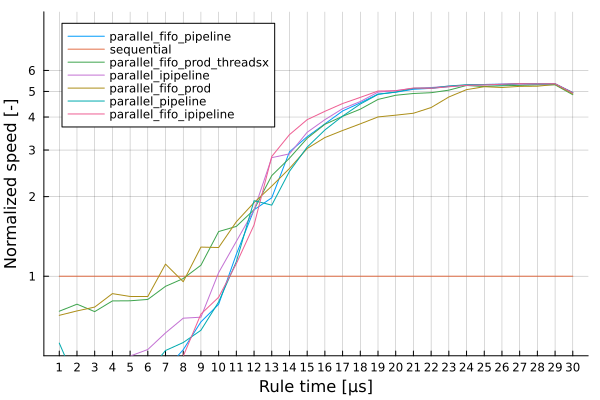

In [61]:
p = plot(
    # xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    yticks=([1:Threads.nthreads(:interactive);], [string(a) for a in 1:Threads.nthreads(:interactive)]),
    xticks=(sizes, [ string(a) for a in sizes ]),
    ylim = (0.5, 10), 
    gridalpha=0.3,
)

for (key, values) in pairs(points)
    plot!(p, sizes, points[:sequential] ./ values, label = string(key))
end

p